# Quick demo of the HealPixRegridder

HealPix regridding is automatically applied during clustering for datasets with latitude/longitude coordinates.


In [9]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN
from toad.regridding import HealPixRegridder
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from toad.shifts import ASDETECT

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [10]:
td = TOAD("test_data/global_mean_summer_tas.nc", log_level="INFO")
td.data = td.data.coarsen(lat=2, lon=2, boundary="trim").reduce(np.mean)

In [11]:
td.compute_shifts("tas", method=ASDETECT(), overwrite=True)

INFO: New shifts variable tas_dts: min/mean/max=-0.854/0.014/0.979 using 34992 grid cells. Skipped 0.0% grid cells: 0 NaN, 0 constant.


In [12]:
#  Regular latitude/longitude grids have denser sampling near the poles,
# which can bias clustering results. So for lat/lon coords, a regridder
# is applied by default: the HealPixRegridder.
regridder = HealPixRegridder()

# So you don't need to pass it, like is done here, but if you do you can also access the cluster results in the healpix grid, see 3 cells below.
td.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=10),
    overwrite=True,
    regridder=regridder,
)
# Takes 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")

INFO: New cluster variable tas_dts_cluster: Identified 12 clusters in 3,286 pts; Left 0.8% as noise (27 pts).


Identified clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11]


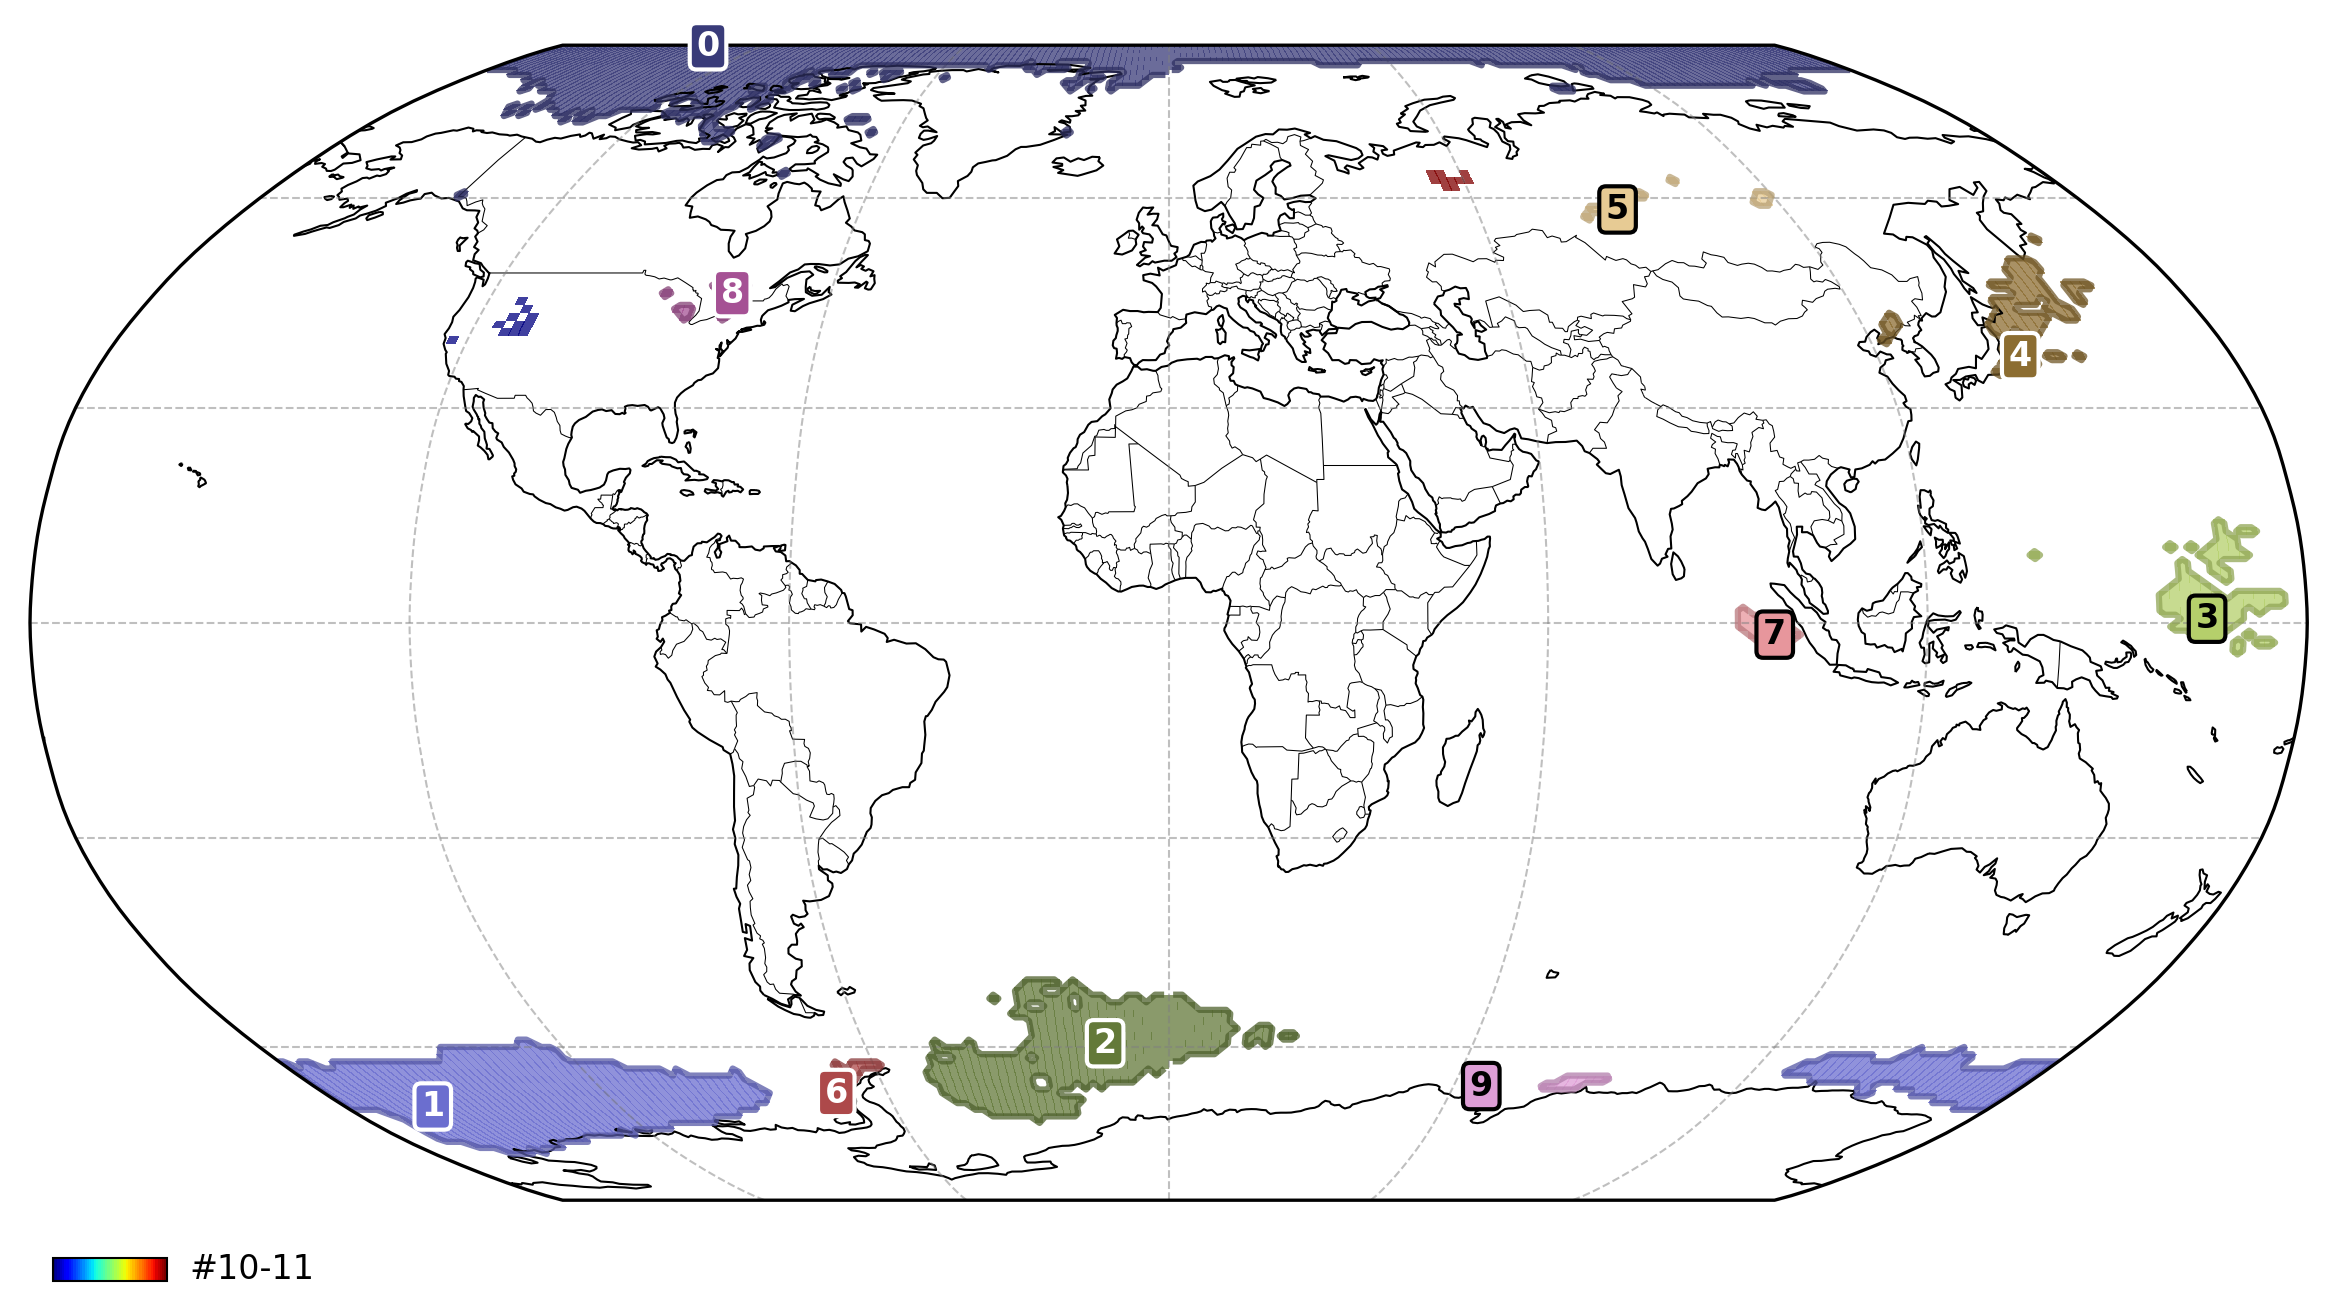

In [13]:
td.plot.cluster_map("tas", cluster_ids=range(10), map_style={"projection": "global"});

,time,hp_pix,vals,lat,lon,cluster
0,2025.0,19960,0.583333,10.806923,169.453125,0
1,2025.0,20215,0.583333,10.199918,167.343750,0
2,2025.0,20726,0.583333,8.989299,165.937500,0
3,2025.0,21495,0.541667,7.180756,168.046875,0
4,2025.0,22003,0.541667,5.979157,162.421875,0
...,...,...,...,...,...,...
1958,2097.0,6482,0.541667,47.357576,155.526316,6
1959,2097.0,6711,0.562500,46.571847,154.396552,6
1960,2097.0,6712,0.541667,46.571847,155.948276,6
1961,2097.0,7180,0.562500,44.993880,150.750000,6


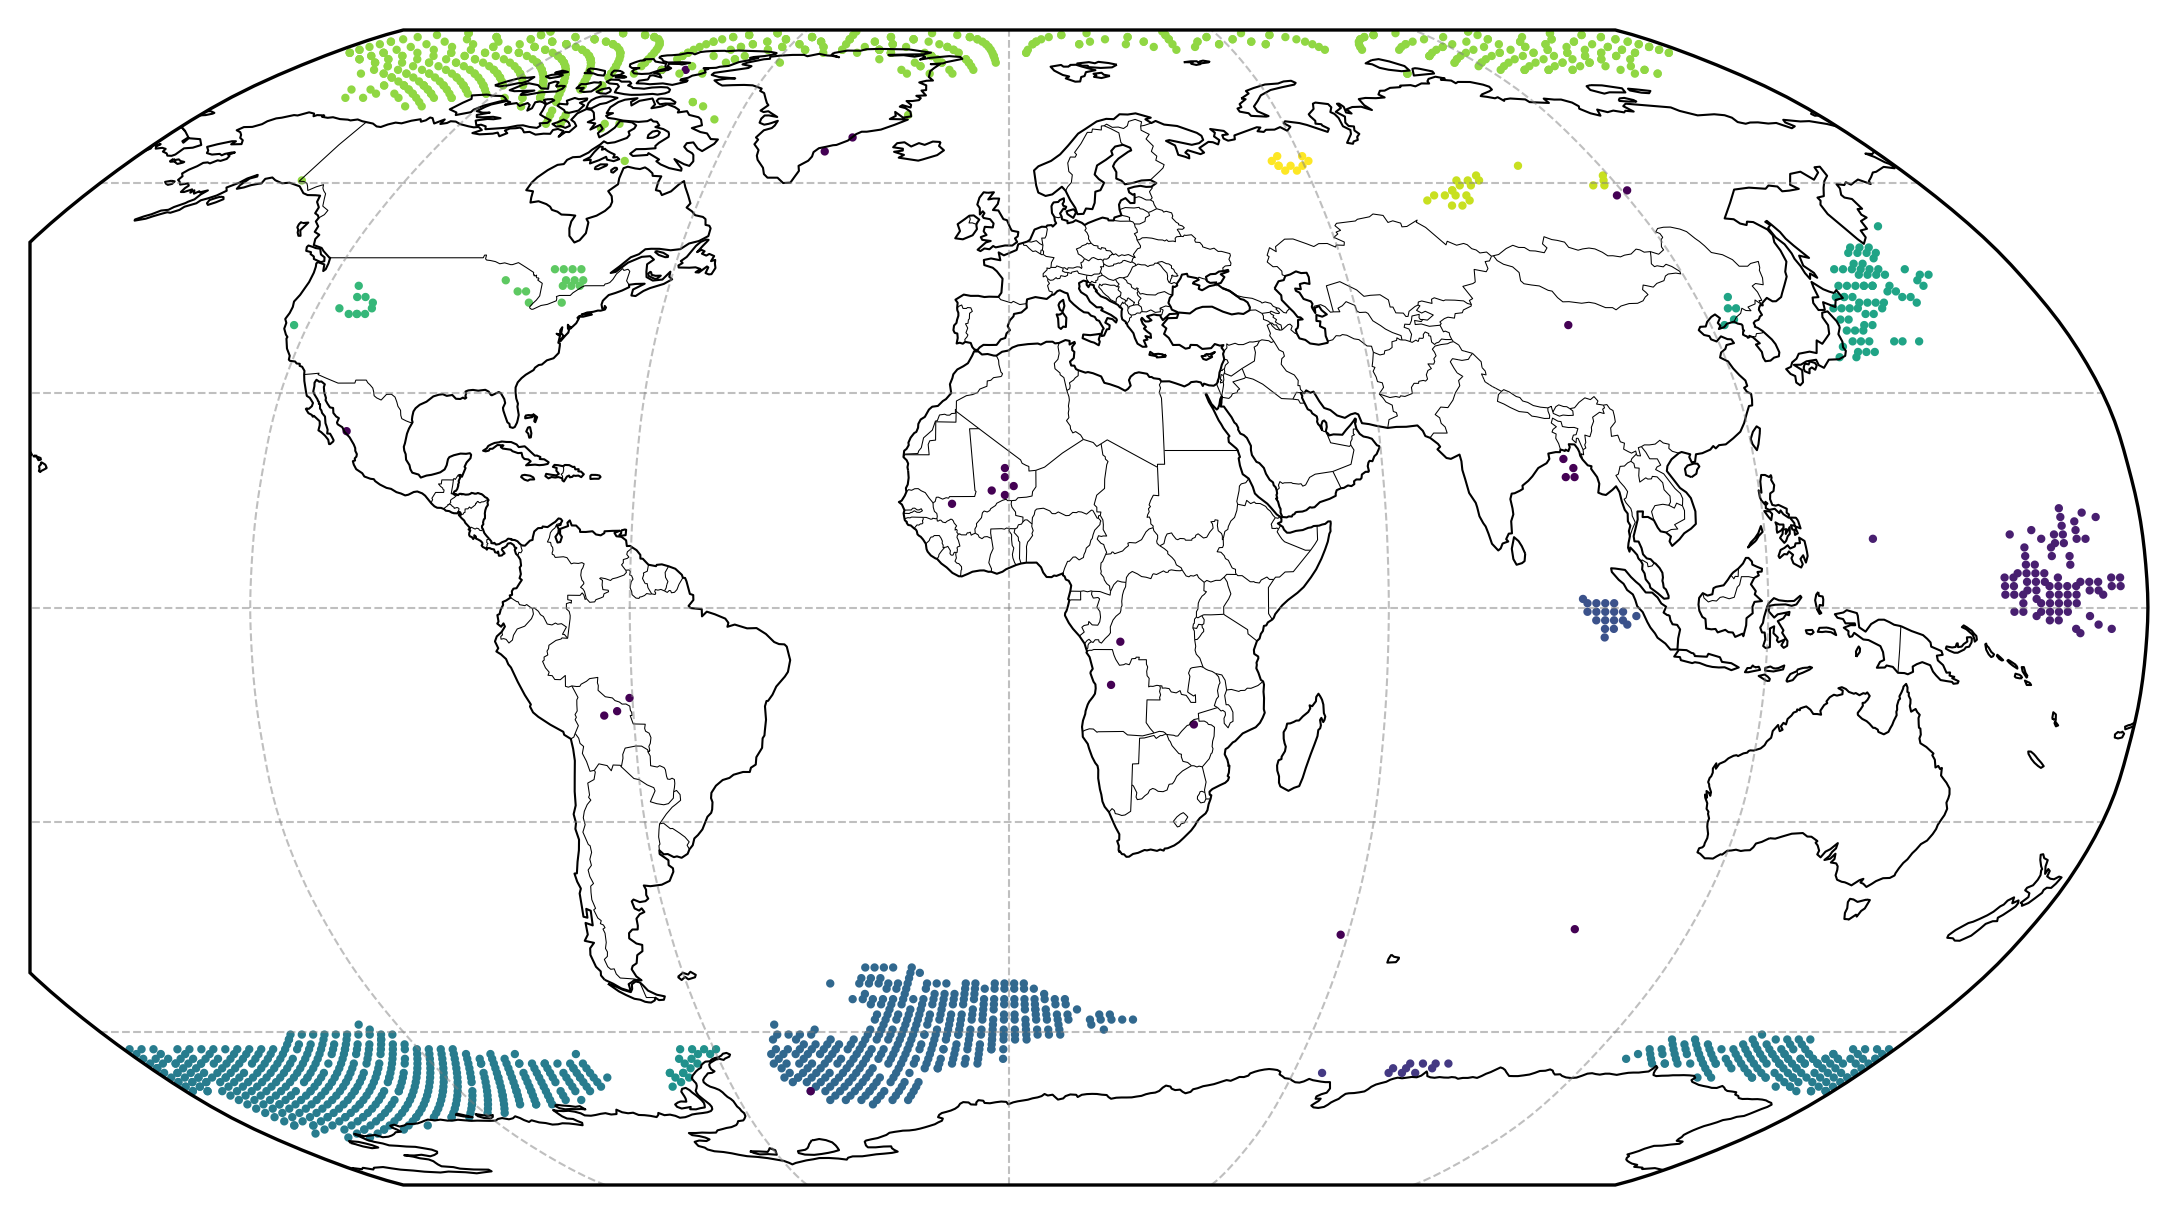

In [14]:
# we can also access the clusters in the healpix grid
display(regridder.df_healpix)

# and plot the data in the healpix grid
lats, lons, cluster = (
    regridder.df_healpix.lat,
    regridder.df_healpix.lon,
    regridder.df_healpix.cluster,
)
fig, ax = td.plot.map(map_style={"projection": "global"})
ax.scatter(lons, lats, c=cluster, s=1, transform=ccrs.PlateCarree())

## `with` vs. `without` regridder

Let's compare results


In [15]:
# drop old clusters
td.data = td.data.drop_vars(td.cluster_vars)

# only use the northern hemisphere
# td.data = td.data.sel(lat=slice(35, 90))

# compute clusters with regridder
td.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=5),
)

# compute clusters without regridder
td.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=5),
    disable_regridder=True,
)

INFO: New cluster variable tas_dts_cluster: Identified 16 clusters in 3,286 pts; Left 0.6% as noise (19 pts).
INFO: New cluster variable tas_dts_cluster_1: Identified 86 clusters in 3,286 pts; Left 10.3% as noise (338 pts).


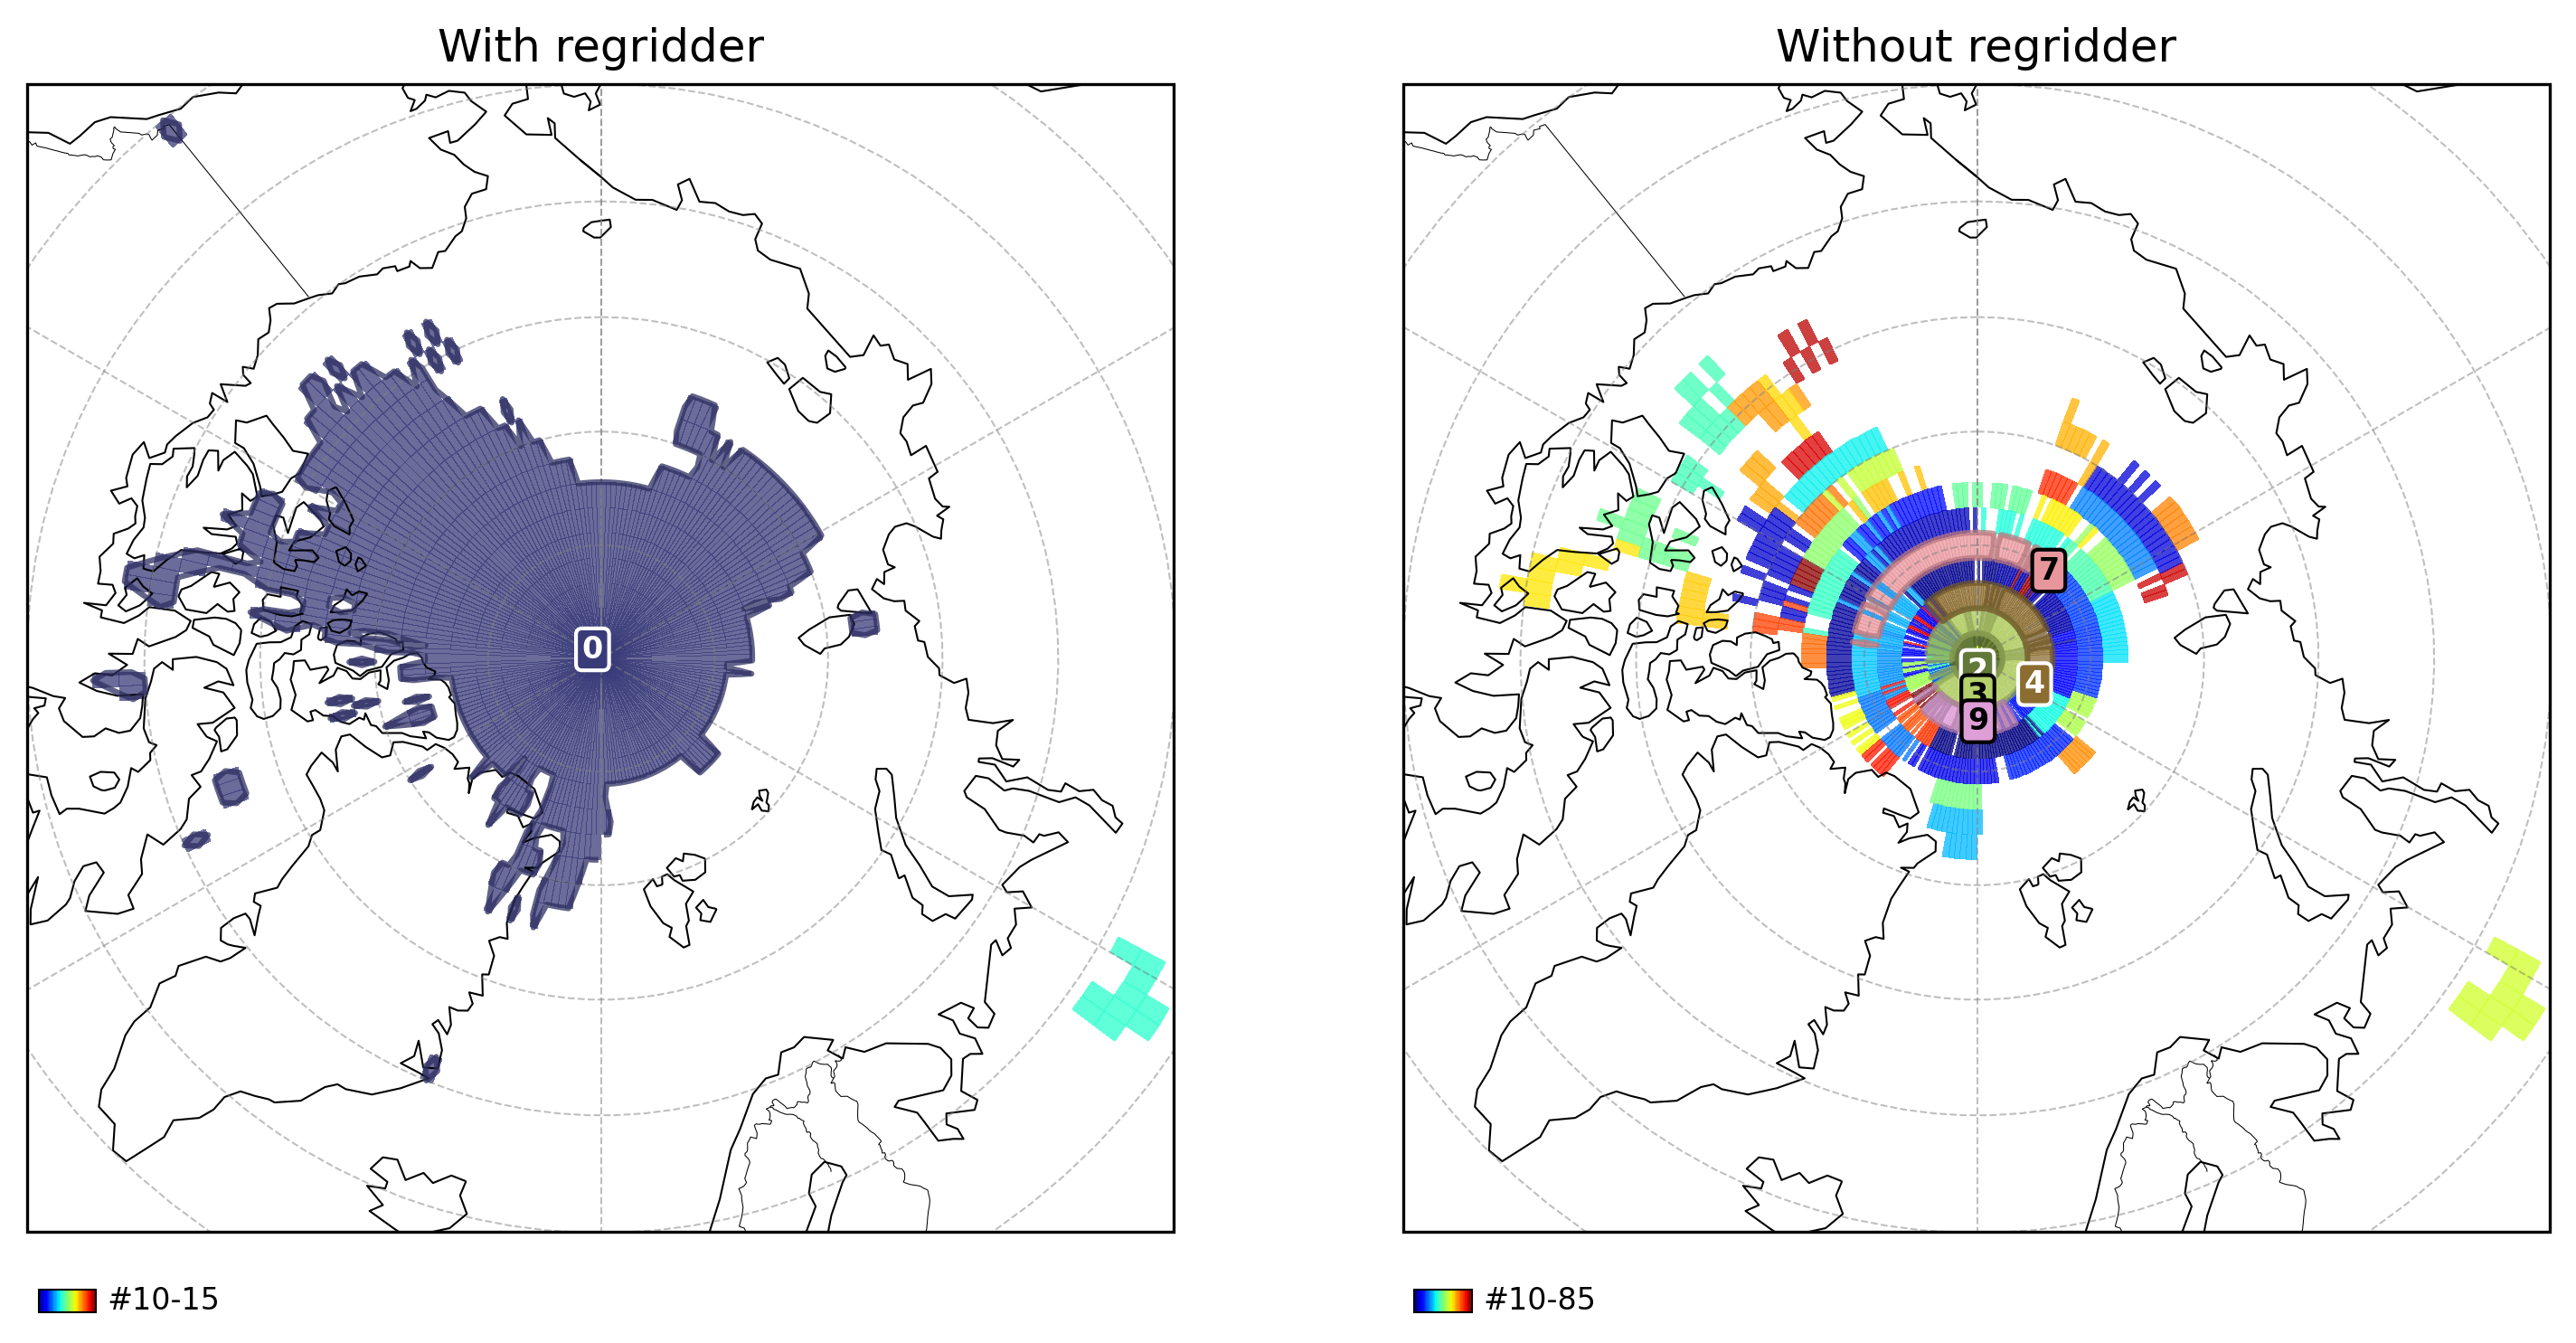

In [18]:
fig, axs = td.plot.map(
    1, 2, map_style={"projection": "north_pole", "add_labels": False}, figsize=(12, 6.5)
)

td.plot.cluster_map("tas_dts_cluster", cluster_ids=range(10), ax=axs[0])
td.plot.cluster_map("tas_dts_cluster_1", cluster_ids=range(10), ax=axs[1])
axs[0].set_title("With regridder")
axs[1].set_title("Without regridder");